In [1]:
import Pkg; Pkg.activate(@__DIR__)
using RobotZoo
using RobotDynamics
using LinearAlgebra
using StaticArrays
using SparseArrays
using MeshCat, GeometryBasics, Colors, CoordinateTransformations, Rotations
using Plots
using BilinearControl
using BilinearControl.EDMD

  Activating project at `~/.julia/dev/BilinearControl/examples`
┌ Info: Precompiling BilinearControl [6c574e7f-3a92-4ac2-914e-58f10933cbed]
└ @ Base loading.jl:1423


In [4]:
const RD = RobotDynamics

RobotDynamics

In [5]:
function defcolor(c1, c2, c1def, c2def)
    if !isnothing(c1) && isnothing(c2)
        c2 = c1
    else
        c1 = isnothing(c1) ? c1def : c1
        c2 = isnothing(c2) ? c2def : c2
    end
    c1,c2
end

function set_mesh!(vis0, model::RobotZoo.Pendulum; 
    color=nothing, color2=nothing)
    
    vis = vis0["robot"]
    dim = Vec(0.1, 0.3, 0.1)
    cart = Rect3D(-dim/2, dim)
    hinge = Cylinder(Point3f0(-dim[1]/2,0,dim[3]/2), Point3f0(dim[1],0,dim[3]/2), 0.03f0)
    c1,c2 = defcolor(color,color2, colorant"blue", colorant"red")

    pole = Cylinder(Point3f0(0,0,0),Point3f0(0,0,model.len),0.01f0)
    mass = HyperSphere(Point3f0(0,0,model.len), 0.05f0)
    setobject!(vis["cart","box"],   cart, MeshPhongMaterial(color=isnothing(color) ? colorant"green" : color))
    setobject!(vis["cart","hinge"], hinge, MeshPhongMaterial(color=colorant"black"))
    setobject!(vis["cart","pole","geom","cyl"], pole, MeshPhongMaterial(color=c1))
    setobject!(vis["cart","pole","geom","mass"], mass, MeshPhongMaterial(color=c2))
    settransform!(vis["cart","pole"], Translation(0.75*dim[1],0,dim[3]/2))
end

function visualize_state!(vis, model::RobotZoo.Pendulum, x)
    θ = x[1]
    q = expm((pi-θ) * @SVector [1,0,0])
    settransform!(vis["robot","cart","pole","geom"], LinearMap(UnitQuaternion(q)))
end

function visualize!(vis, model::RobotDynamics.AbstractModel, tf::Real, X)
    fps = Int(round((length(X)-1)/tf))
    anim = MeshCat.Animation(fps)
    n = state_dim(model)
    for (k,x) in enumerate(X)
        atframe(anim, k) do
            x = X[k]
            visualize_state!(vis, model, SVector{n}(x)) 
        end
    end
    setanimation!(vis, anim)
end

visualize! (generic function with 1 method)

In [6]:
function create_test_U(num_knots, m, U_type::String)

    if U_type == "constant"
        u0 = 2 .* ones(m)
    elseif U_type == "random"
        u0 = 0.01 .* ones(m)
    end

    U = [u0]

    for k in 1:(num_knots-1)

        if U_type == "constant"
            u = 2 .* ones(m)
        elseif U_type == "random"
            u = -5 .+ (10*rand(Float64, m))
        end

        push!(U, u)

    end
    
    return U

end

function create_training_U(num_knots, m)

    u0 = -3 .* ones(m)
    U = [u0]

    for k in 1:(num_knots-1)

        u = -3 .+ (6*rand(Float64, m))
        push!(U, u)

    end

    # for k in (Int(round((num_knots-1)/2) + 1)) : (num_knots - 1)

    #     u = 2 .* ones(m)
    #     push!(U, u)
    # end
    
    # return U

    # for k in 1 : (Int(round((num_knots-1)/2)))

    #     u = -3 .+ (6*rand(Float64, m))
    #     push!(U, u)

    # end

    # for k in (Int(round((num_knots-1)/2) + 1)) : (num_knots - 1)

    #     u = -2 .* ones(m)
    #     push!(U, u)
    # end
    
    return U

end

create_training_U (generic function with 1 method)

In [7]:
function simulate(dmodel, x0, U, dt)

    t = 0.0
    x = x0
    X = [x]
    T = [t]
    
    for k in 1:length(U)

        u = U[k]
        x = RD.discrete_dynamics(dmodel, x, u, t, dt)
        t += dt
        push!(X, x)
        append!(T, t)

    end

    return T, X

end

function simulate_bilinear(F, C, g, x0, z0, U)
    
    x = x0
    z = z0
    Z = [z]
    X = [x]

    for k in 1:length(U)

        u = U[k]
        
        z = F * z + (C * z) .* u
        x = g * z

        push!(Z, z)
        push!(X, x)
        
    end

    return X, Z

end

simulate_bilinear (generic function with 1 method)

In [8]:
# define temporal properties
dt = 0.01
tf = 3

num_knots = Int(tf/dt + 1)

# define pendulum initial properties
x0 = [0.5*pi, 0]

# define Pendulum model
model = RobotZoo.Pendulum()

state_dim(model) = 2
control_dim(model) = 1

dmodel = RD.DiscretizedDynamics{RD.RK4}(model)
n, m = RD.dims(dmodel)

(2, 1, 2)

In [11]:
# create predefined control trajectory
U_sim = create_training_U(num_knots, m)

# randomly simulate model and store trajectory
time, X_sim = simulate(dmodel, x0, U_sim, dt);

In [12]:
# determine eigenfunction state values
Z_sim, Zu_sim, z0 = build_eigenfunctions(X_sim, U_sim, ["state", "sine", "cosine"], [0, 0, 0])

# learn bilinear model
F, C, g = learn_bilinear_model(X_sim, Z_sim, Zu_sim, ["lasso", "lasso"]; edmd_weights=[0.0], mapping_weights=[0.0]);

In [13]:
bi_X, _ = simulate_bilinear(F, C, g, x0, z0, U_sim);

In [14]:
global vis = Visualizer()
set_mesh!(vis, model)
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8703
└ @ MeshCat /home/brian/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8703))

In [15]:
visualize!(vis, model, tf, bi_X)

In [16]:
visualize!(vis, model, tf, X_sim)

In [17]:
# extract individual state histories
X_mat = mapreduce(permutedims, vcat, X_sim)'
bi_X_mat = mapreduce(permutedims, vcat, bi_X)'

theta_sim = X_mat[1, :]
omega_sim = X_mat[2, :]

theta_bilinear = bi_X_mat[1, :]
omega_bilinear = bi_X_mat[2, :]

302-element Vector{Float64}:
  0.0
 -0.31581229175025954
 -0.6285147287573801
 -0.8951333046208517
 -1.0771665089854818
 -1.2948356241713033
 -1.371366749910647
 -1.5203962761711196
 -1.6876960402612533
 -1.7869869516335684
 -1.9388762428542323
 -2.2192843041710377
 -2.3654456765379193
  ⋮
  2.376412308008732
  2.2719748527312107
  2.351931614418602
  2.4563212581961147
  2.4772037096310053
  2.4328275352963367
  2.428505146192901
  2.5225834932532174
  2.450244822784982
  2.533728025377938
  2.501889509404876
  2.5280633560720993

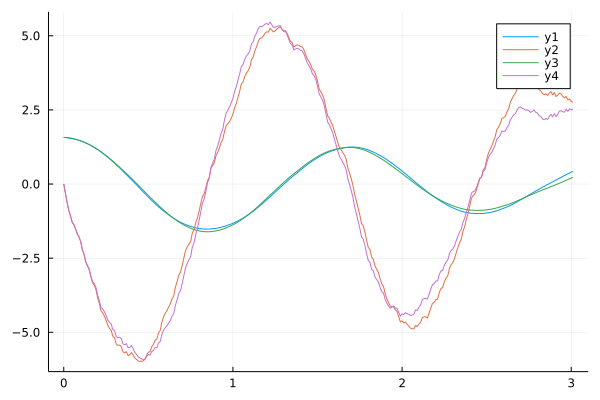

In [18]:
plot(time, theta_sim)
plot!(time, omega_sim)

plot!(time, theta_bilinear)
plot!(time, omega_bilinear)

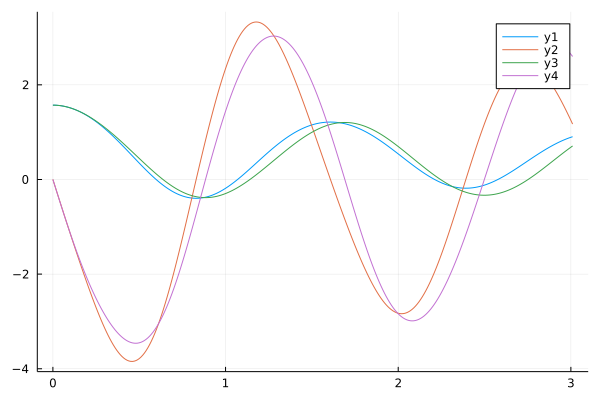

In [19]:
U_test = create_test_U(num_knots, m, "constant")

time_test, X_test = simulate(dmodel, x0, U_test, dt)
X_test_mat = mapreduce(permutedims, vcat, X_test)'

bi_X_test, _ = simulate_bilinear(F, C, g, x0, z0, U_test)
bi_X_test_mat = mapreduce(permutedims, vcat, bi_X_test)'

# extract individual state histories
theta_test_sim = X_test_mat[1, :]
omega_test_sim = X_test_mat[2, :]

theta_test_bilinear = bi_X_test_mat[1, :]
omega_test_bilinear = bi_X_test_mat[2, :]

plot(time_test, theta_test_sim)
plot!(time_test, omega_test_sim)

plot!(time_test, theta_test_bilinear)
plot!(time_test, omega_test_bilinear)